### imports and preparations


In [1]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

In [2]:
# Configuration

# Dataset paths
NO_DETECTOR_DIR = r"C:\Users\thaim\Videos\AI_LEDS\cropped_no_detector_pictures_balanced_90k"
DETECTOR_DIR = r"C:\Users\thaim\Videos\AI_LEDS\cropped_detector_pictures"

# Output paths
OUTPUT_DIR = r"C:\Users\thaim\Videos\AI_LEDS\model_output"
MODEL_NAME = "detector_classifier_mobilenetv2"

# Image settings
IMG_SIZE = 224  # MobileNetV2 standard input size
BATCH_SIZE = 32  # Adjust based on GPU memory (16/32/64)

# Training settings
EPOCHS = 30
LEARNING_RATE = 0.001
TEST_SIZE = 0.1      # 10% for test
VAL_SIZE = 0.1       # 10% for validation (from remaining 90%)

# Data augmentation for detector class (minority class)
AUGMENTATION_ENABLED = False

# Create output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

In [3]:
# Load and prepare dataset

def load_image_paths(directory, label):
    """Load all image paths from directory recursively"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    paths = []
    
    dir_path = Path(directory)
    for ext in image_extensions:
        paths.extend(dir_path.rglob(f'*{ext}'))
    
    return [(str(p), label) for p in paths]

print("Loading image paths...")
no_detector_data = load_image_paths(NO_DETECTOR_DIR, 0)  # Label 0 = No detector
detector_data = load_image_paths(DETECTOR_DIR, 1)        # Label 1 = Detector

print(f"No detector images: {len(no_detector_data)}")
print(f"Detector images: {len(detector_data)}")
print(f"Total images: {len(no_detector_data) + len(detector_data)}")
print(f"Class imbalance ratio: {len(no_detector_data) / len(detector_data):.2f}:1")

# Combine and shuffle
all_data = no_detector_data + detector_data
np.random.shuffle(all_data)

# Separate paths and labels
image_paths = [d[0] for d in all_data]
labels = np.array([d[1] for d in all_data])

# Split: first 10% for test, then split remaining into train/val
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=TEST_SIZE, stratify=labels, random_state=42
)

# Split remaining into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE/(1-TEST_SIZE), stratify=y_temp, random_state=42
)

print(f"\nDataset split:")
print(f"Train: {len(X_train)} images")
print(f"Validation: {len(X_val)} images")
print(f"Test: {len(X_test)} images")
print(f"\nTrain class distribution:")
print(f"  No detector: {np.sum(y_train == 0)}")
print(f"  Detector: {np.sum(y_train == 1)}")

Loading image paths...
No detector images: 90000
Detector images: 90493
Total images: 180493
Class imbalance ratio: 0.99:1

Dataset split:
Train: 144393 images
Validation: 18050 images
Test: 18050 images

Train class distribution:
  No detector: 72000
  Detector: 72393


## PyTorch Training (Alternative Implementation)

In [4]:
# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from tqdm import tqdm

print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.1+cpu
CUDA available: False


In [5]:
# Build PyTorch Model (MobileNetV2 Transfer Learning) - BALANCED DATASET

# Check class distribution
n_class_0 = np.sum(y_train == 0)
n_class_1 = np.sum(y_train == 1)

print(f"\nClass distribution (balanced dataset):")
print(f"  No detector (class 0): {n_class_0:,} images")
print(f"  Detector (class 1): {n_class_1:,} images")
print(f"  Ratio: {n_class_0/n_class_1:.2f}:1")

class DetectorClassifier(nn.Module):
    def __init__(self):
        super(DetectorClassifier, self).__init__()
        
        # Load pre-trained MobileNetV2
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        
        # Freeze base layers
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False
        
        # Replace classifier
        in_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # No Sigmoid - BCEWithLogitsLoss applies it internally
        )
    
    def forward(self, x):
        return self.mobilenet(x)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_torch = DetectorClassifier().to(device)

# Loss function - no class weights (balanced dataset)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model_torch.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (PyTorch doesn't have verbose parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Print model info
total_params = sum(p.numel() for p in model_torch.parameters())
trainable_params = sum(p.numel() for p in model_torch.parameters() if p.requires_grad)

print(f"\nPyTorch Model Summary:")
print(f"  Device: {device}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters: {total_params - trainable_params:,}")


Class distribution (balanced dataset):
  No detector (class 0): 72,000 images
  Detector (class 1): 72,393 images
  Ratio: 0.99:1

PyTorch Model Summary:
  Device: cpu
  Total parameters: 2,387,969
  Trainable parameters: 164,097
  Frozen parameters: 2,223,872


c:\Users\thaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# PyTorch Dataset and DataLoader with Selective Augmentation

class DetectorDataset(Dataset):
    """Custom PyTorch Dataset with class-specific augmentation"""
    def __init__(self, image_paths, labels, augment_transform=None, no_augment_transform=None, augment_class=None):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_transform = augment_transform
        self.no_augment_transform = no_augment_transform
        self.augment_class = augment_class  # Only augment this class (e.g., 1 for detector)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply augmentation only to specified class
        if self.augment_class is not None and label == self.augment_class and self.augment_transform is not None:
            image = self.augment_transform(image)
        elif self.no_augment_transform is not None:
            image = self.no_augment_transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

# Define transforms
# Augmentation for detector class (minority class) - matches TensorFlow augmentation
augment_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2),  # Similar to brightness_range=[0.8, 1.2]
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) if AUGMENTATION_ENABLED else transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# No augmentation for no_detector class and validation/test
no_augment_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with selective augmentation
print(f"Creating PyTorch datasets with selective augmentation...")
print(f"  Augmentation enabled: {AUGMENTATION_ENABLED}")
if AUGMENTATION_ENABLED:
    print(f"  Augmenting only detector class (label=1) for training")

train_dataset_torch = DetectorDataset(
    X_train, y_train, 
    augment_transform=augment_transform,
    no_augment_transform=no_augment_transform,
    augment_class=1  # Only augment detector images (minority class)
)

val_dataset_torch = DetectorDataset(
    X_val, y_val, 
    augment_transform=None,
    no_augment_transform=no_augment_transform,
    augment_class=None  # No augmentation for validation
)

test_dataset_torch = DetectorDataset(
    X_test, y_test, 
    augment_transform=None,
    no_augment_transform=no_augment_transform,
    augment_class=None  # No augmentation for test
)

# Create dataloaders - num_workers=0 for Windows compatibility with large datasets
print("\nCreating DataLoaders...")
train_loader = DataLoader(train_dataset_torch, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset_torch, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset_torch, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nPyTorch Datasets created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"\n✓ PyTorch augmentation strategy matches TensorFlow (detector class only)")
print(f"✓ Using single-threaded loading (num_workers=0) for stability with large datasets")

Creating PyTorch datasets with selective augmentation...
  Augmentation enabled: False

Creating DataLoaders...

PyTorch Datasets created:
  Train batches: 4513
  Validation batches: 565
  Test batches: 565

✓ PyTorch augmentation strategy matches TensorFlow (detector class only)
✓ Using single-threaded loading (num_workers=0) for stability with large datasets


In [ ]:
# Train PyTorch Model with Progress Tracking

from tqdm.auto import tqdm
import time

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print("  [Training...]")
    start_time = time.time()
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device).unsqueeze(1)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Print progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            elapsed = time.time() - start_time
            batches_per_sec = (batch_idx + 1) / elapsed
            print(f"    Batch {batch_idx+1}/{len(loader)} | Loss: {loss.item():.4f} | Speed: {batches_per_sec:.2f} batch/s")
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    elapsed = time.time() - start_time
    print(f"  Training complete in {elapsed:.1f}s")
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print("  [Validating...]")
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
print("Starting PyTorch training...")
print(f"Device: {device}")
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
print(f"Training on {len(train_loader)} batches per epoch")
print("="*60)

best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

history_torch = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Training epochs
for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*60}")
    
    # Train
    train_loss, train_acc = train_epoch(model_torch, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model_torch, val_loader, criterion, device)
    
    # Store history
    history_torch['train_loss'].append(train_loss)
    history_torch['train_acc'].append(train_acc)
    history_torch['val_loss'].append(val_loss)
    history_torch['val_acc'].append(val_acc)
    
    # Print detailed progress
    print(f"\nResults:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"  GPU Memory: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"  Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model_torch.state_dict(), os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_pytorch_best.pth'))
        print("  ✓ Best model saved")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{patience_limit}")
        if patience_counter >= patience_limit:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

print("\n" + "="*60)
print("PyTorch training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*60)

Starting PyTorch training...
Device: cpu
GPU Memory Allocated: 0.00 MB
Training on 4513 batches per epoch

Epoch 1/30
  [Training...]


c:\Users\thaim\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


    Batch 10/4513 | Loss: 0.3144 | Speed: 0.93 batch/s
    Batch 20/4513 | Loss: 0.2343 | Speed: 0.96 batch/s
    Batch 30/4513 | Loss: 0.1250 | Speed: 0.97 batch/s
    Batch 40/4513 | Loss: 0.1065 | Speed: 0.96 batch/s
    Batch 50/4513 | Loss: 0.5126 | Speed: 0.96 batch/s
    Batch 60/4513 | Loss: 0.1287 | Speed: 0.97 batch/s
    Batch 70/4513 | Loss: 0.3417 | Speed: 0.97 batch/s
    Batch 80/4513 | Loss: 0.6068 | Speed: 0.97 batch/s
    Batch 90/4513 | Loss: 0.0350 | Speed: 0.97 batch/s
    Batch 100/4513 | Loss: 0.1267 | Speed: 0.97 batch/s
    Batch 110/4513 | Loss: 0.0629 | Speed: 0.97 batch/s
    Batch 120/4513 | Loss: 0.1600 | Speed: 0.97 batch/s
    Batch 130/4513 | Loss: 0.1113 | Speed: 0.97 batch/s
    Batch 140/4513 | Loss: 0.0823 | Speed: 0.97 batch/s
    Batch 150/4513 | Loss: 0.2520 | Speed: 0.97 batch/s
    Batch 160/4513 | Loss: 0.0137 | Speed: 0.96 batch/s
    Batch 170/4513 | Loss: 0.0225 | Speed: 0.96 batch/s
    Batch 180/4513 | Loss: 0.0847 | Speed: 0.95 batch/s
 

✓ Loaded PyTorch model from: C:\Users\thaim\Downloads\TORCH-20260118T090349Z-3-001\TORCH\detector_classifier_mobilenetv2_pytorch_best.pth
✓ Device: cpu

Evaluating 61 images...

PYTORCH EVALUATION RESULTS
Total images evaluated:  61

Predictions:
  Detector:     30 images (49.2%)
  No Detector:  31 images (50.8%)

Raw Probability Stats (prob > 0.5 = Detector):
  Mean: 0.4918032725
  Min:  0.0000000000e+00
  Max:  1.0000000000e+00

⚠️  Model outputs extreme values (very close to 0 or 1)
   This may be due to training bug (double sigmoid in loss function)

DETAILED RESULTS (all images) - showing exact probability values
#    Filename                            Prediction   Raw Probability     
----------------------------------------------------------------------------------------------------
1    0.jpg                               No Detector  0.0000000000e+00
2    1.jpg                               No Detector  0.0000000000e+00
3    2.jpg                               No Detector  0.

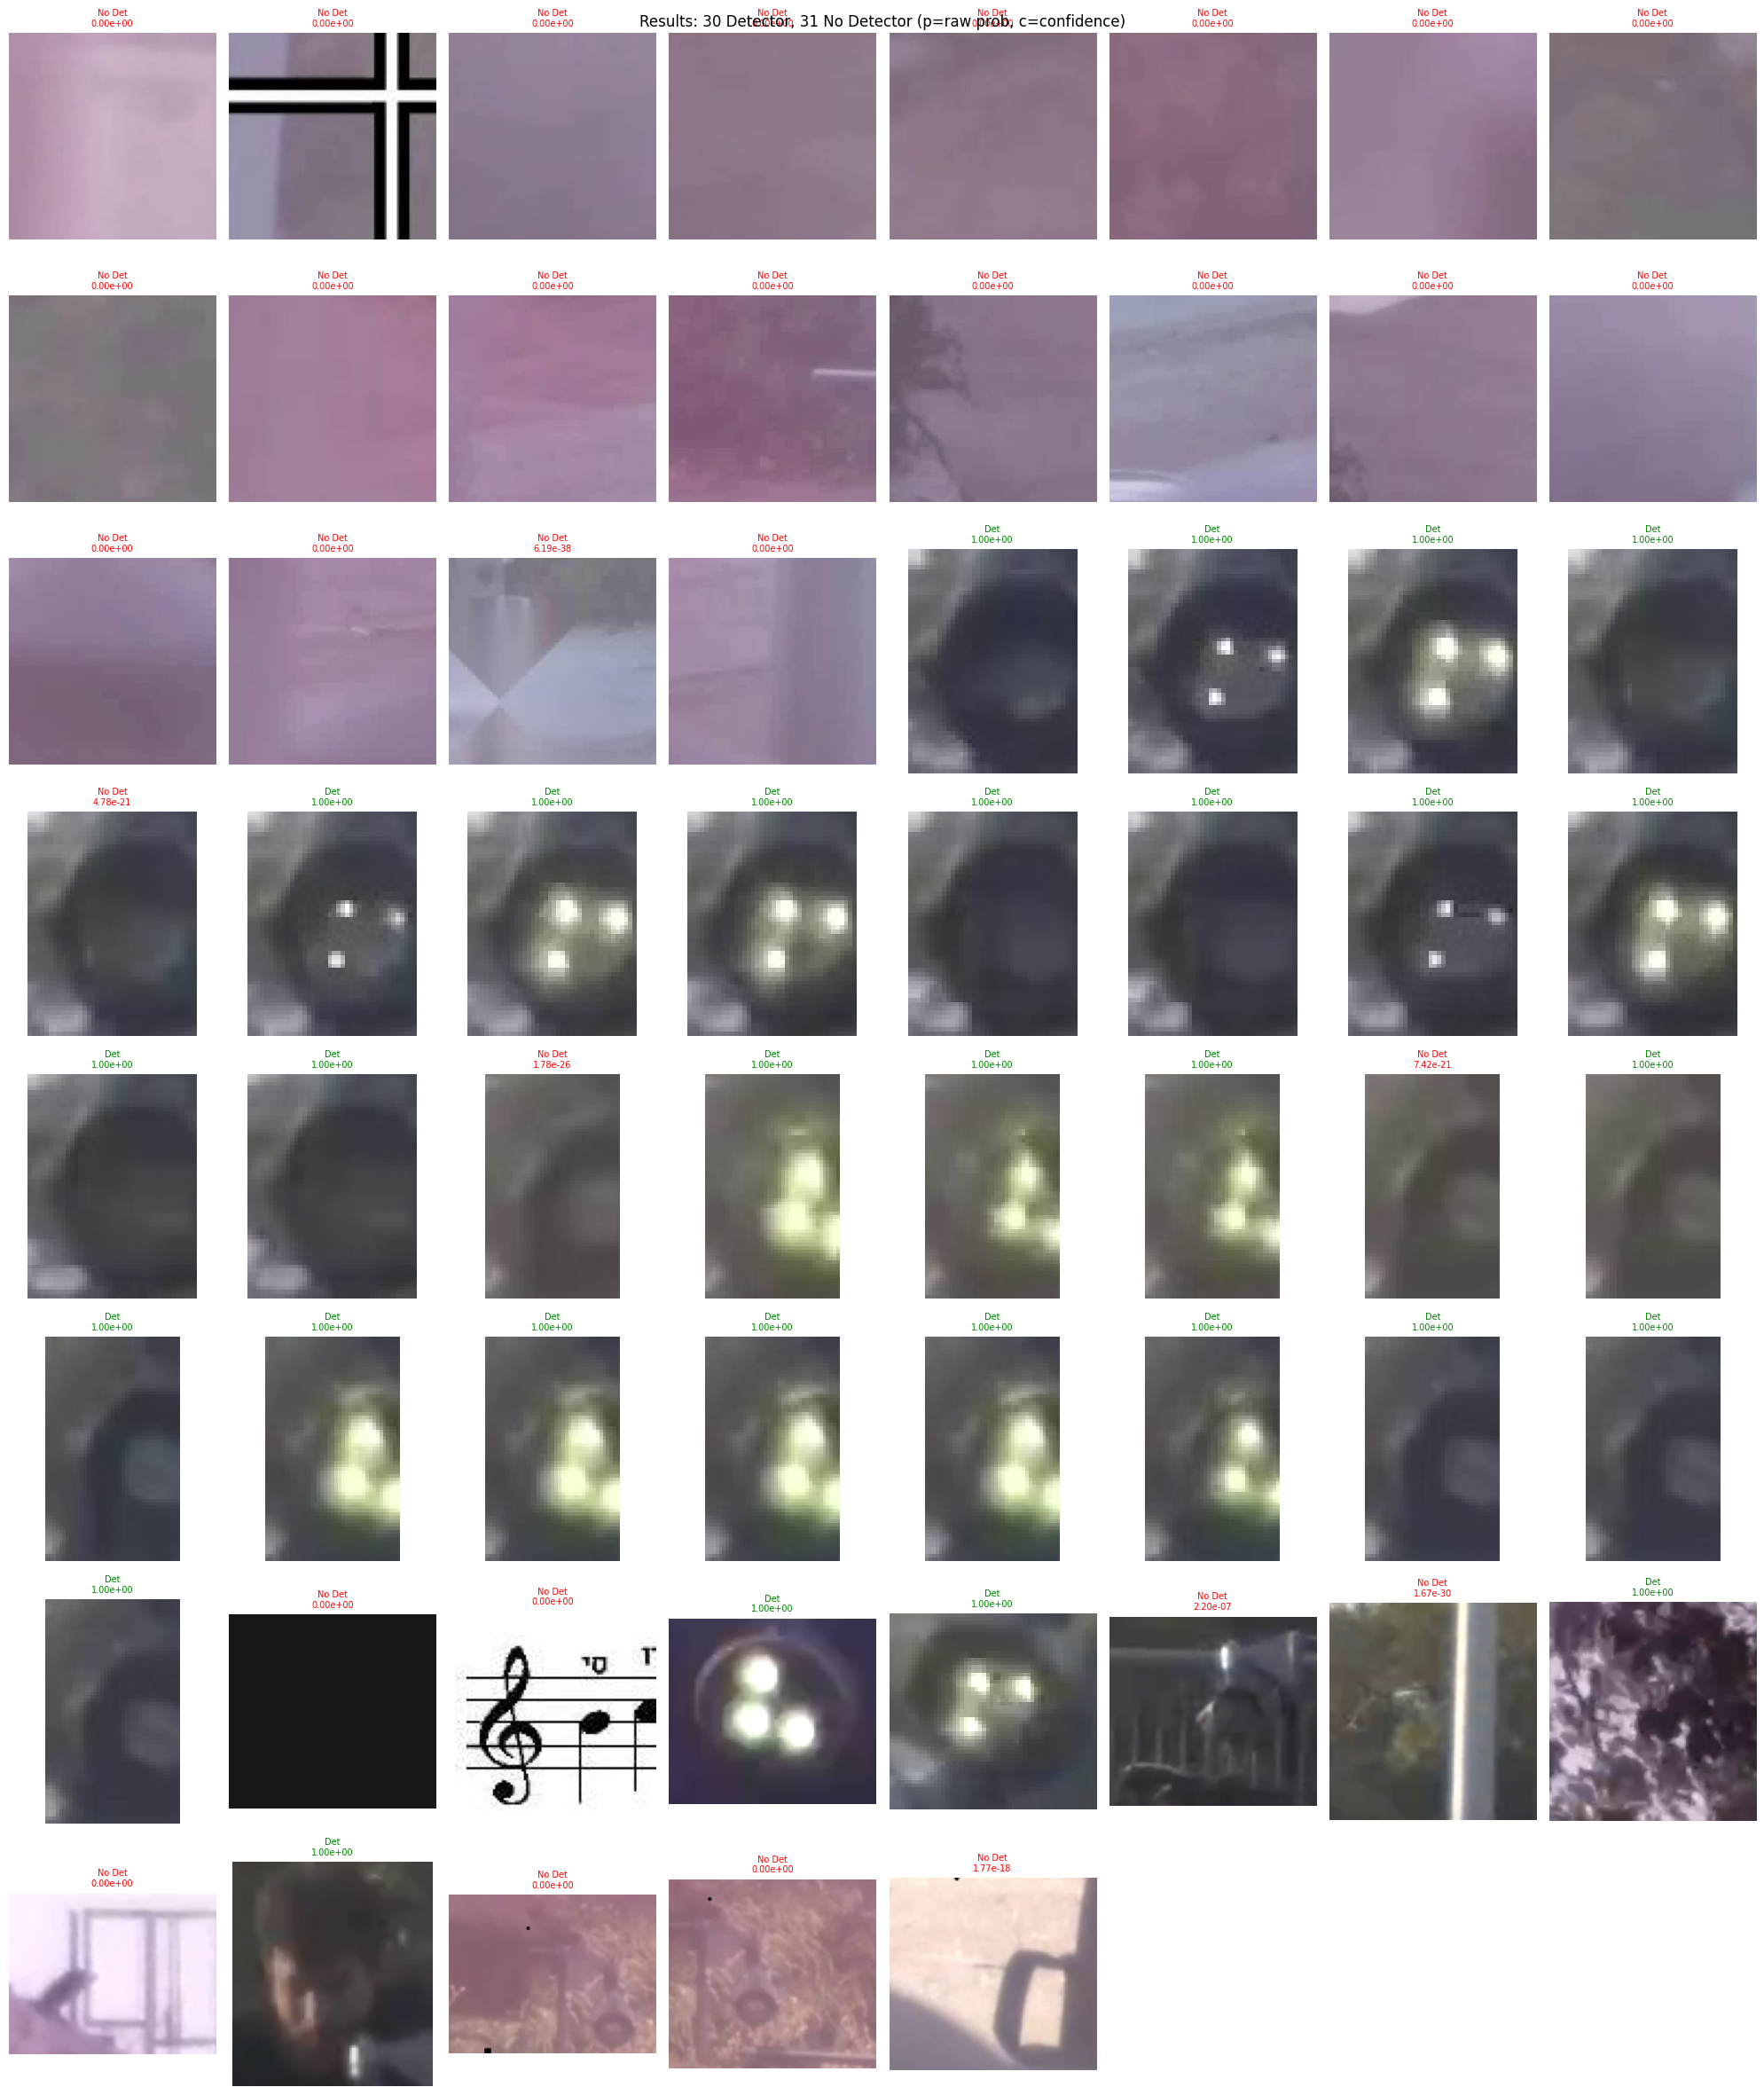

In [15]:
# Standalone PyTorch Evaluate & Save - runs independently without training cells
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# === CONFIGURATION ===
IMG_SIZE = 224
WEIGHTS_PATH = r"C:\Users\thaim\Downloads\TORCH-20260118T090349Z-3-001\TORCH\detector_classifier_mobilenetv2_pytorch_best.pth"
OUTPUT_DIR = r"C:\Users\thaim\Downloads\tests torch\output"
MODEL_NAME = "detector_classifier_mobilenetv2"
TEST_FOLDER = r"C:\Users\thaim\Downloads\tests torch\test picture"
SAVE_RESULTS = True
MAX_DISPLAY = 100  # Max images to show in grid (set high to show all)

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# === MODEL ARCHITECTURE ===
class DetectorClassifier(nn.Module):
    def __init__(self):
        super(DetectorClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(weights=None)
        in_features = self.mobilenet.classifier[1].in_features
        self.mobilenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.mobilenet(x)

# === LOAD MODEL ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_torch = DetectorClassifier().to(device)
model_torch.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device, weights_only=True))
model_torch.eval()
print(f"✓ Loaded PyTorch model from: {WEIGHTS_PATH}")
print(f"✓ Device: {device}")

# === PREPROCESSING ===
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# === EVALUATION FUNCTION ===
def evaluate_folder(folder_path, max_display=MAX_DISPLAY):
    """Evaluate all images in folder, show results with raw probabilities"""
    folder = Path(folder_path)
    image_paths = list(folder.glob('*.jpg')) + list(folder.glob('*.png')) + list(folder.glob('*.jpeg')) + list(folder.glob('*.bmp'))
    
    if not image_paths:
        print(f"No images found in {folder_path}")
        return None
    
    all_preds, all_probs, all_names = [], [], []
    
    print(f"\nEvaluating {len(image_paths)} images...")
    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model_torch(img_tensor)
            prob = output.item()  # Model already has Sigmoid, don't apply twice!
        
        all_probs.append(prob)
        all_preds.append(1 if prob > 0.5 else 0)
        all_names.append(img_path.name)
    
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    # === RESULTS SUMMARY ===
    n_detector = np.sum(all_preds == 1)
    n_no_detector = np.sum(all_preds == 0)
    confidences = np.maximum(all_probs, 1 - all_probs)
    
    print("\n" + "="*70)
    print("PYTORCH EVALUATION RESULTS")
    print("="*70)
    print(f"Total images evaluated:  {len(image_paths)}")
    print(f"\nPredictions:")
    print(f"  Detector:     {n_detector} images ({n_detector/len(all_preds)*100:.1f}%)")
    print(f"  No Detector:  {n_no_detector} images ({n_no_detector/len(all_preds)*100:.1f}%)")
    print(f"\nRaw Probability Stats (prob > 0.5 = Detector):")
    print(f"  Mean: {np.mean(all_probs):.10f}")
    print(f"  Min:  {np.min(all_probs):.10e}")  # Scientific notation to see tiny values
    print(f"  Max:  {np.max(all_probs):.10e}")
    print(f"\n⚠️  Model outputs extreme values (very close to 0 or 1)")
    print(f"   This may be due to training bug (double sigmoid in loss function)")
    print("="*70)
    
    # === DETAILED TABLE with scientific notation ===
    print("\n" + "="*100)
    print("DETAILED RESULTS (all images) - showing exact probability values")
    print("="*100)
    print(f"{'#':<4} {'Filename':<35} {'Prediction':<12} {'Raw Probability':<20}")
    print("-"*100)
    for i, (name, pred, prob) in enumerate(zip(all_names, all_preds, all_probs)):
        pred_str = "Detector" if pred == 1 else "No Detector"
        # Show scientific notation for extreme values
        print(f"{i+1:<4} {name[:33]:<35} {pred_str:<12} {prob:.10e}")
    print("="*100)
    
    # === VISUAL GRID (all images up to max_display) ===
    n_display = min(len(image_paths), max_display)
    cols = min(8, n_display)
    rows = (n_display + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 3*rows))
    axes = np.array(axes).flatten() if n_display > 1 else [axes]
    
    for i in range(n_display):
        img = plt.imread(image_paths[i])
        axes[i].imshow(img)
        pred_class = "Det" if all_preds[i] == 1 else "No Det"
        raw_prob = all_probs[i]
        color = 'green' if all_preds[i] == 1 else 'red'
        # Show scientific notation for extreme values
        axes[i].set_title(f"{pred_class}\n{raw_prob:.2e}", color=color, fontsize=7)
        axes[i].axis('off')
    
    for ax in axes[n_display:]:
        ax.axis('off')
    
    plt.suptitle(f"Results: {n_detector} Detector, {n_no_detector} No Detector (p=raw prob, c=confidence)", fontsize=12)
    plt.tight_layout()
    if SAVE_RESULTS:
        plt.savefig(os.path.join(OUTPUT_DIR, 'pytorch_evaluation_all.png'), dpi=200)
    plt.show()
    
    return {'preds': all_preds, 'probs': all_probs, 'paths': image_paths, 'names': all_names}

# === RUN EVALUATION ===
if Path(TEST_FOLDER).exists():
    results = evaluate_folder(TEST_FOLDER)
else:
    print(f"⚠️ Test folder not found: {TEST_FOLDER}")

## TensorFlow Training (Original Implementation)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")



Steps per epoch: 13792
Validation steps: 1724


In [ ]:
# Create data generators with augmentation

# Augmentation for training detector images only (minority class)
train_detector_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
) if AUGMENTATION_ENABLED else ImageDataGenerator(rescale=1./255)

# No augmentation for no_detector class and validation/test
train_no_detector_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(paths, labels, datagen, batch_size, augment_class=None):
    """Create data generator from image paths"""
    def generator():
        indices = np.arange(len(paths))
        while True:
            np.random.shuffle(indices)
            for start in range(0, len(paths), batch_size):
                end = min(start + batch_size, len(paths))
                batch_indices = indices[start:end]
                
                batch_images = []
                batch_labels = []
                
                for idx in batch_indices:
                    img_path = paths[idx]
                    label = labels[idx]
                    
                    img = tf.keras.preprocessing.image.load_img(
                        img_path, target_size=(IMG_SIZE, IMG_SIZE)
                    )
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    
                    # Apply augmentation only to specified class
                    if augment_class is None or label == augment_class:
                        img_array = datagen.random_transform(img_array)
                    
                    img_array = img_array / 255.0
                    batch_images.append(img_array)
                    batch_labels.append(label)
                
                yield np.array(batch_images), np.array(batch_labels)
    
    return generator

# Create generators
train_generator = create_generator(
    X_train, y_train, train_detector_datagen, BATCH_SIZE, augment_class=1
)

val_generator = create_generator(
    X_val, y_val, val_test_datagen, BATCH_SIZE
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

In [6]:
# Build model with MobileNetV2 transfer learning

# Load pre-trained MobileNetV2 (without top classification layer)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers (transfer learning)
base_model.trainable = False

# Build model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Calculate class weights to handle imbalance
total_samples = len(y_train)
n_class_0 = np.sum(y_train == 0)
n_class_1 = np.sum(y_train == 1)

weight_0 = total_samples / (2 * n_class_0)
weight_1 = total_samples / (2 * n_class_1)

class_weights = {0: weight_0, 1: weight_1}

print(f"\nClass weights:")
print(f"  No detector (class 0): {weight_0:.4f}")
print(f"  Detector (class 1): {weight_1:.4f}")

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Model summary
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

NameError: name 'MobileNetV2' is not defined

In [9]:
# Train model

# Callbacks
callbacks = [
    # Early stopping - stop if validation loss doesn't improve for 5 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate if validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Save best model during training
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir=os.path.join(OUTPUT_DIR, 'logs'),
        histogram_freq=1
    )
]

print("Starting training...")
print("="*60)

# Train model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("Training completed!")

Starting training...
Epoch 1/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.9721 - loss: 0.0758 - precision: 0.8764 - recall: 0.9684
Epoch 1: val_loss improved from None to 0.04495, saving model to C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_best.h5


13792/13792 ━━━━━━━━━━━━━━━━━━━━ 12587s 912ms/step - accuracy: 0.9823 - loss: 0.0498 - precision: 0.9172 - recall: 0.9804 - val_accuracy: 0.9850 - val_loss: 0.0450 - val_precision: 0.9906 - val_recall: 0.9170 - learning_rate: 0.0010
Epoch 2/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9899 - loss: 0.0332 - precision: 0.9523 - recall: 0.9879
Epoch 2: val_loss improved from 0.04495 to 0.04213, saving model to C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_best.h5


13792/13792 ━━━━━━━━━━━━━━━━━━━━ 3405s 247ms/step - accuracy: 0.9906 - loss: 0.0303 - precision: 0.9556 - recall: 0.9884 - val_accuracy: 0.9861 - val_loss: 0.0421 - val_precision: 0.9975 - val_recall: 0.9177 - learning_rate: 0.0010
Epoch 3/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9917 - loss: 0.0263 - precision: 0.9614 - recall: 0.9894
Epoch 3: val_loss improved from 0.04213 to 0.02650, saving model to C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_best.h5


13792/13792 ━━━━━━━━━━━━━━━━━━━━ 7506s 544ms/step - accuracy: 0.9922 - loss: 0.0251 - precision: 0.9637 - recall: 0.9897 - val_accuracy: 0.9919 - val_loss: 0.0265 - val_precision: 0.9680 - val_recall: 0.9833 - learning_rate: 0.0010
Epoch 4/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.9933 - loss: 0.0230 - precision: 0.9689 - recall: 0.9909
Epoch 4: val_loss did not improve from 0.02650
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 6646s 482ms/step - accuracy: 0.9934 - loss: 0.0228 - precision: 0.9695 - recall: 0.9910 - val_accuracy: 0.9896 - val_loss: 0.0309 - val_precision: 0.9905 - val_recall: 0.9457 - learning_rate: 0.0010
Epoch 5/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9939 - loss: 0.0213 - precision: 0.9718 - recall: 0.9914
Epoch 5: val_loss improved from 0.02650 to 0.01948, saving model to C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_best.h5


13792/13792 ━━━━━━━━━━━━━━━━━━━━ 2728s 198ms/step - accuracy: 0.9940 - loss: 0.0208 - precision: 0.9727 - recall: 0.9916 - val_accuracy: 0.9945 - val_loss: 0.0195 - val_precision: 0.9794 - val_recall: 0.9870 - learning_rate: 0.0010
Epoch 6/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9944 - loss: 0.0200 - precision: 0.9743 - recall: 0.9921
Epoch 6: val_loss did not improve from 0.01948
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 2744s 199ms/step - accuracy: 0.9945 - loss: 0.0193 - precision: 0.9749 - recall: 0.9921 - val_accuracy: 0.9904 - val_loss: 0.0301 - val_precision: 0.9949 - val_recall: 0.9463 - learning_rate: 0.0010
Epoch 7/30
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9947 - loss: 0.0187 - precision: 0.9762 - recall: 0.9922
Epoch 7: val_loss did not improve from 0.01948
13792/13792 ━━━━━━━━━━━━━━━━━━━━ 2720s 197ms/step - accuracy: 0.9949 - loss: 0.0183 - precision: 0.9770 - recall: 0.9926 - val_accuracy: 0.9929 - val_loss: 0.0241 - val_precision: 0.98

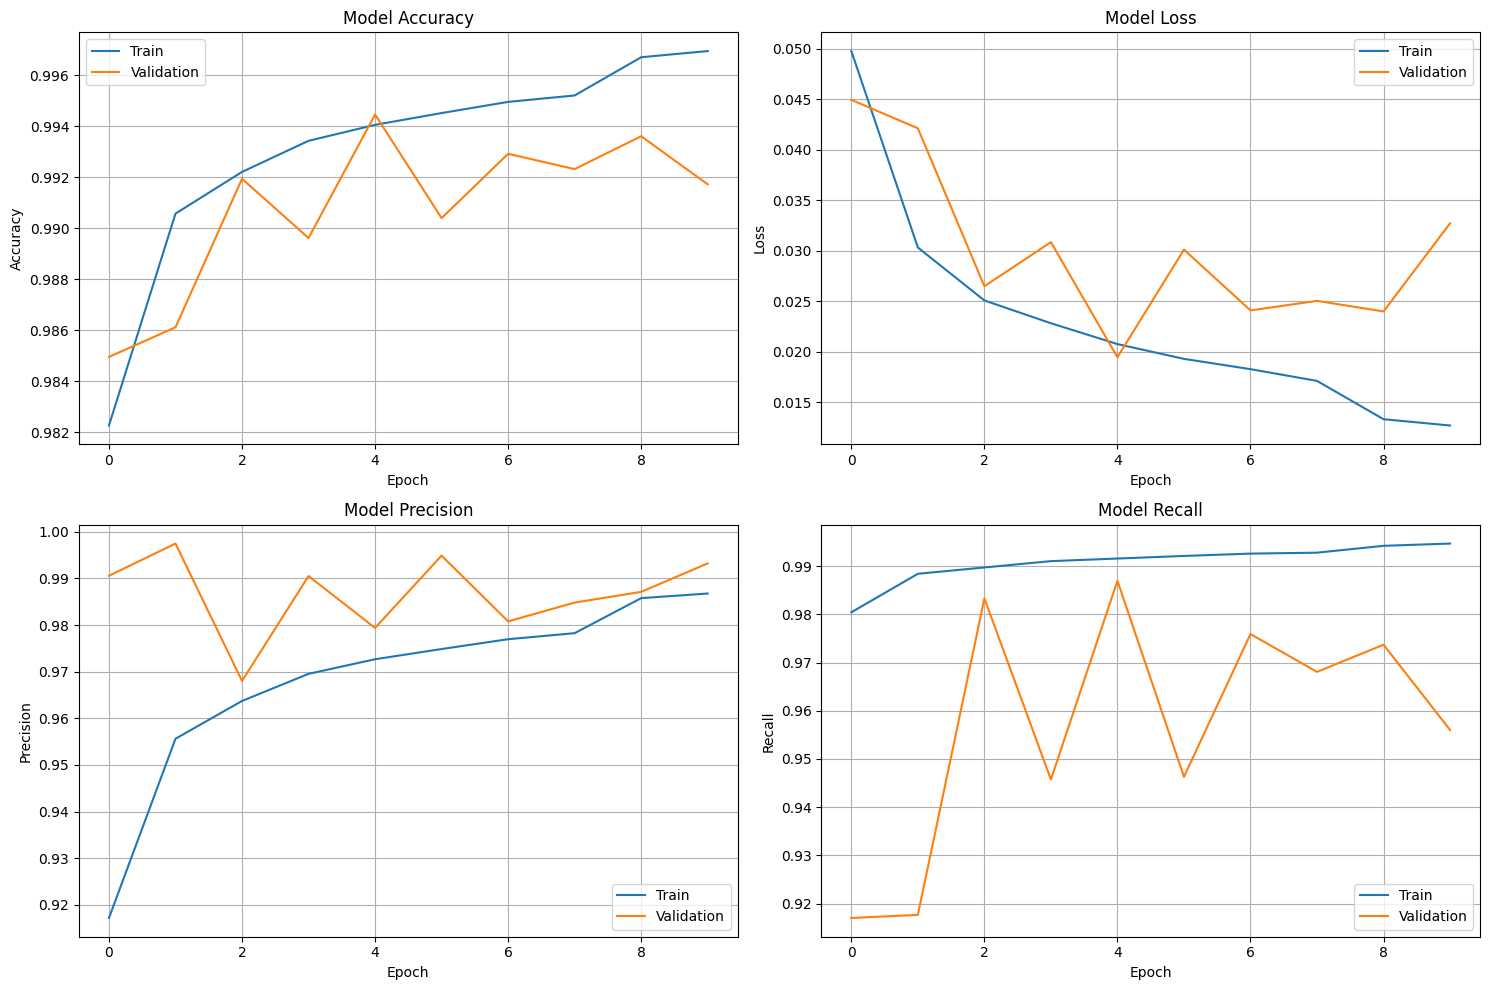


Evaluating on test set...
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 722s 418ms/step - accuracy: 0.9945 - loss: 0.0187 - precision: 0.9795 - recall: 0.9871



TEST SET RESULTS
Loss: 0.0187
Accuracy: 0.9945
Precision: 0.9795
Recall: 0.9871

Saving model...
✓ Saved as .h5: C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_final.h5
✓ Saved as .keras: C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_final.keras
INFO:tensorflow:Assets written to: C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_savedmodel\assets


INFO:tensorflow:Assets written to: C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_savedmodel\assets


Saved artifact at 'C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\detector_classifier_mobilenetv2_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2119340669072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249311184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249310416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2117955926736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249310608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249310800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249311952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249312720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118249312336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2118

In [11]:
# Evaluate and save model

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300)
plt.show()

# Evaluate on test set
print("\nEvaluating on test set...")
test_generator = create_generator(X_test, y_test, val_test_datagen, BATCH_SIZE)
test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(tf.data.AUTOTUNE)

test_steps = len(X_test) // BATCH_SIZE
test_results = model.evaluate(test_dataset, steps=test_steps, verbose=1)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"Precision: {test_results[2]:.4f}")
print(f"Recall: {test_results[3]:.4f}")
print("="*60)

# Save final model in multiple formats
print("\nSaving model...")

# Save as .h5 (single file - legacy format)
h5_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
model.save(h5_path)
print(f"✓ Saved as .h5: {h5_path}")

# Save as .keras (native Keras 3 format)
keras_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.keras')
model.save(keras_path)
print(f"✓ Saved as .keras: {keras_path}")

# Save as SavedModel (TensorFlow format - use export() for Keras 3.x)
savedmodel_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_savedmodel')
model.export(savedmodel_path)
print(f"✓ Saved as SavedModel: {savedmodel_path}")

# Save training configuration
config = {
    'model_name': MODEL_NAME,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'test_accuracy': float(test_results[1]),
    'test_precision': float(test_results[2]),
    'test_recall': float(test_results[3]),
    'total_images': len(all_data),
    'train_images': len(X_train),
    'val_images': len(X_val),
    'test_images': len(X_test),
    'class_weights': {0: float(weight_0), 1: float(weight_1)},
    'no_detector_count': len(no_detector_data),
    'detector_count': len(detector_data)
}

config_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_config.json')
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"✓ Saved config: {config_path}")

print("\n" + "="*60)
print("ALL FILES SAVED SUCCESSFULLY")
print("="*60)
print(f"\nOutput directory: {OUTPUT_DIR}")
print(f"\nFiles created:")
print(f"  - {MODEL_NAME}_final.h5 (legacy H5 format)")
print(f"  - {MODEL_NAME}_final.keras (native Keras 3 format - recommended)")
print(f"  - {MODEL_NAME}_savedmodel/ (TensorFlow SavedModel for deployment)")
print(f"  - {MODEL_NAME}_best.h5 (best model during training)")
print(f"  - {MODEL_NAME}_config.json (training configuration)")
print(f"  - training_history.png (training plots)")
print(f"  - logs/ (TensorBoard logs)")
print("="*60)

DETAILED TEST SET ANALYSIS

Generating predictions for test set...
Total predictions generated: 55168

1. CONFUSION MATRIX


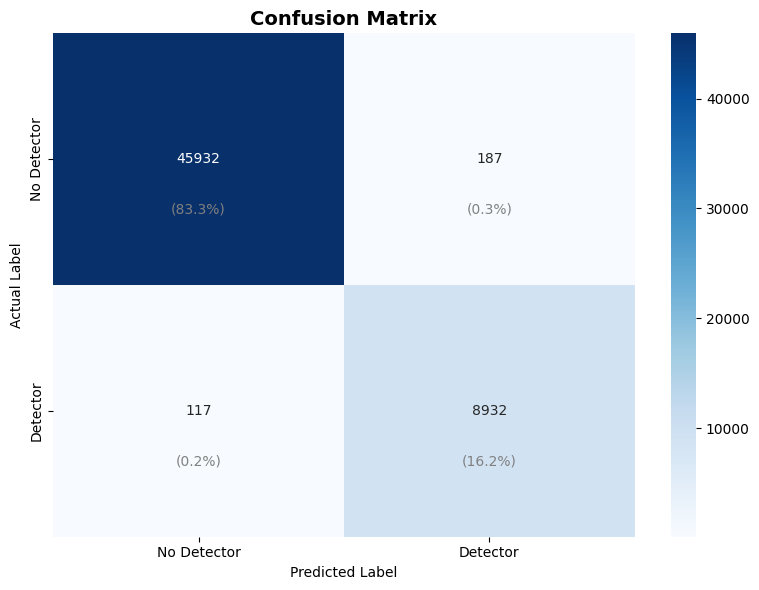


True Negatives (Correct 'No Detector'):  45,932
False Positives (Wrong 'Detector'):      187  ⚠️  (False alarms)
False Negatives (Missed 'Detector'):     117  ❌ (Missed detections - CRITICAL!)
True Positives (Correct 'Detector'):     8,932

2. CLASSIFICATION REPORT
              precision    recall  f1-score   support

 No Detector     0.9975    0.9959    0.9967     46119
    Detector     0.9795    0.9871    0.9833      9049

    accuracy                         0.9945     55168
   macro avg     0.9885    0.9915    0.9900     55168
weighted avg     0.9945    0.9945    0.9945     55168


✓ Saved classification report: C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\model_output\classification_report.txt

3. ROC CURVE (Receiver Operating Characteristic)


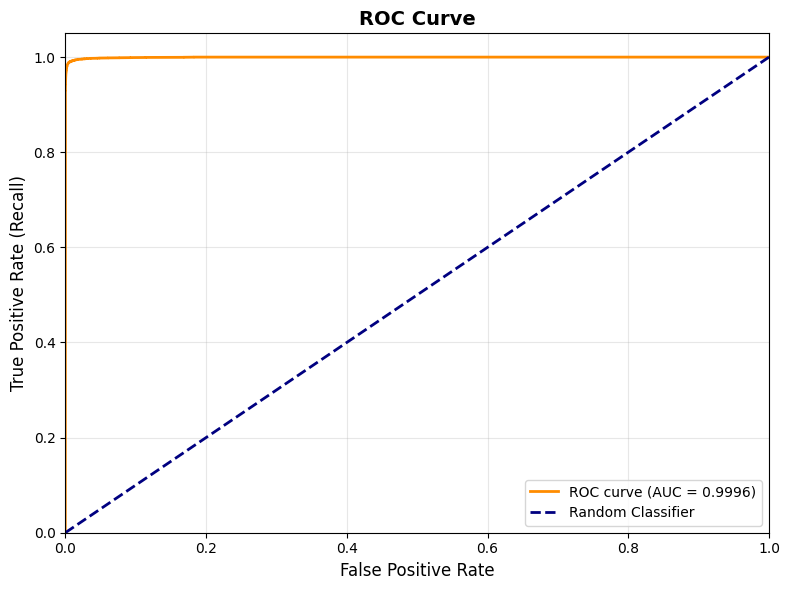


AUC Score: 0.9996
Interpretation:
  - AUC = 1.0: Perfect classifier
  - AUC = 0.9-1.0: Excellent
  - AUC = 0.8-0.9: Good
  - AUC = 0.7-0.8: Fair
  - AUC = 0.5: Random guessing

4. SAMPLE PREDICTIONS (Visual Inspection)


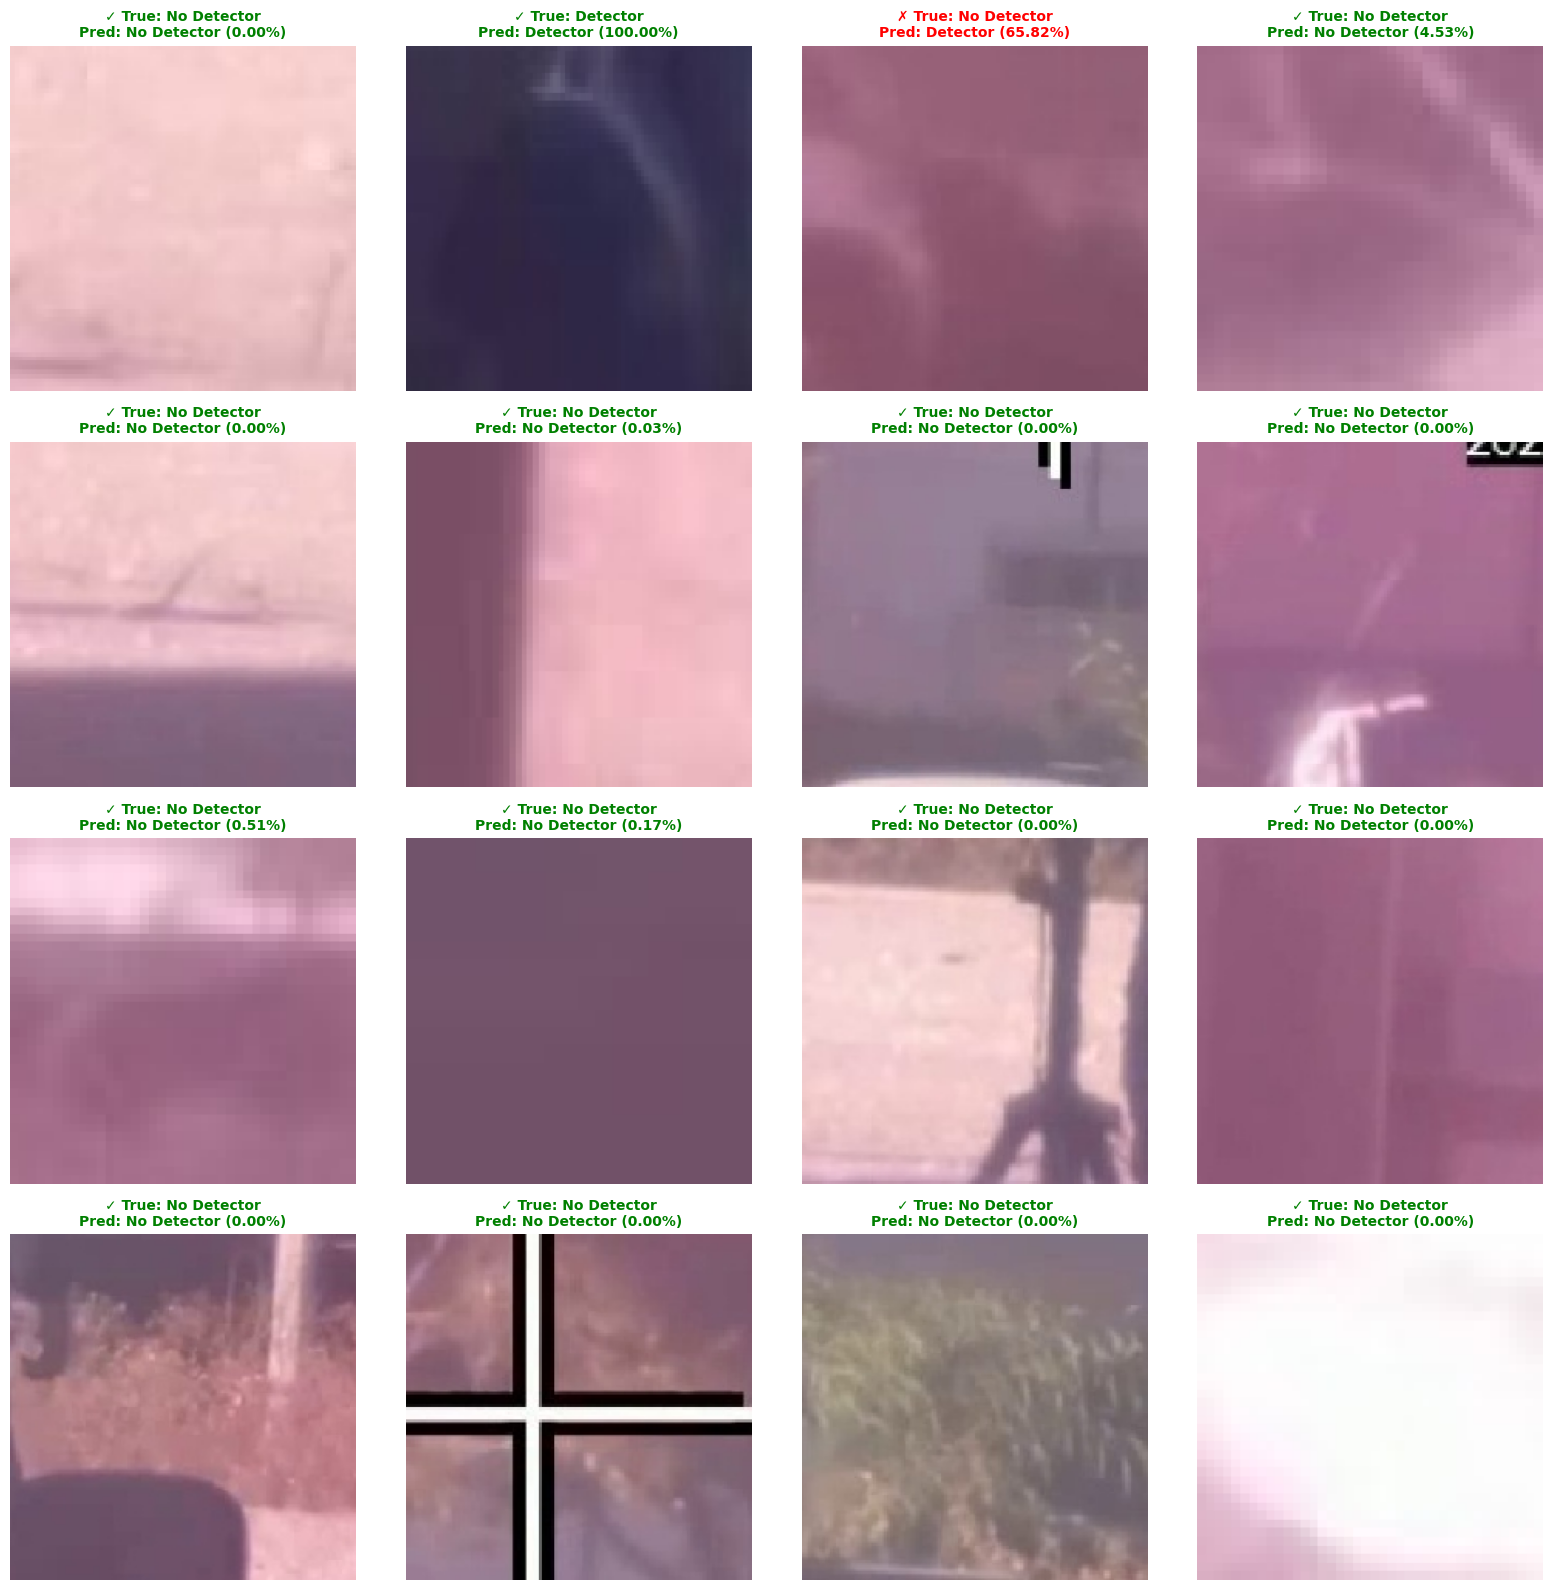


✓ Displayed 16 random test samples
  Green = Correct prediction
  Red = Incorrect prediction

5. ERROR ANALYSIS

Total errors: 304 out of 55168 (0.55%)

False Positives (False Alarms): 187
False Negatives (Missed Detectors): 117 ⚠️  CRITICAL!

⚠️  Missed detector examples (paths):
  1. C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\cropped_detector_pictures\045_1205 (4)-1_47x73\frame_00100_47x73.jpg (Confidence: 26.06%)
  2. C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\cropped_no_detector_pictures\frame_00321\100x100\crop_003.jpg (Confidence: 4.72%)
  3. C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\cropped_no_detector_pictures\frame_01831\120x120\crop_010.jpg (Confidence: 24.23%)
  4. C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\cropped_no_detector_pictures\frame_01688\20x20\crop_010.jpg (Confidence: 10.26%)
  5. C:\Users\talha\Downloads\AI_GAS_ALIGNMENT_DETECTORFORM\cropped_detector_pictures\025_1205 (4)(4)-1_81x33\frame_00089_81x33.jpg (Confiden

In [12]:
# Detailed Test Analysis: Confusion Matrix, Classification Report, Sample Predictions & ROC Curve

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

print("="*60)
print("DETAILED TEST SET ANALYSIS")
print("="*60)

# Get all test predictions (batch by batch to handle large dataset)
all_predictions = []
all_true_labels = []
all_pred_probs = []

print("\nGenerating predictions for test set...")
test_gen_fixed = create_generator(X_test, y_test, val_test_datagen, BATCH_SIZE)
test_dataset_fixed = tf.data.Dataset.from_generator(
    test_gen_fixed,
    output_signature=(
        tf.TensorSpec(shape=(None, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).take(test_steps)

for batch_images, batch_labels in test_dataset_fixed:
    # Get predictions
    pred_probs = model.predict(batch_images, verbose=0)
    pred_probs = pred_probs.flatten()
    pred_classes = (pred_probs > 0.5).astype(int)
    
    all_predictions.extend(pred_classes)
    all_true_labels.extend(batch_labels.numpy())
    all_pred_probs.extend(pred_probs)

all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_pred_probs = np.array(all_pred_probs)

print(f"Total predictions generated: {len(all_predictions)}")

# 1. CONFUSION MATRIX
print("\n" + "="*60)
print("1. CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Detector', 'Detector'],
            yticklabels=['No Detector', 'Detector'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300)
plt.show()

# Detailed confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Correct 'No Detector'):  {tn:,}")
print(f"False Positives (Wrong 'Detector'):      {fp:,}  ⚠️  (False alarms)")
print(f"False Negatives (Missed 'Detector'):     {fn:,}  ❌ (Missed detections - CRITICAL!)")
print(f"True Positives (Correct 'Detector'):     {tp:,}")

# 2. CLASSIFICATION REPORT
print("\n" + "="*60)
print("2. CLASSIFICATION REPORT")
print("="*60)

class_names = ['No Detector', 'Detector']
report = classification_report(all_true_labels, all_predictions, 
                               target_names=class_names, digits=4)
print(report)

# Save report
report_path = os.path.join(OUTPUT_DIR, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(report)
print(f"\n✓ Saved classification report: {report_path}")

# 3. ROC CURVE & AUC
print("\n" + "="*60)
print("3. ROC CURVE (Receiver Operating Characteristic)")
print("="*60)

fpr, tpr, thresholds = roc_curve(all_true_labels, all_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'roc_curve.png'), dpi=300)
plt.show()

print(f"\nAUC Score: {roc_auc:.4f}")
print("Interpretation:")
print("  - AUC = 1.0: Perfect classifier")
print("  - AUC = 0.9-1.0: Excellent")
print("  - AUC = 0.8-0.9: Good")
print("  - AUC = 0.7-0.8: Fair")
print("  - AUC = 0.5: Random guessing")

# 4. SAMPLE PREDICTIONS VISUALIZATION
print("\n" + "="*60)
print("4. SAMPLE PREDICTIONS (Visual Inspection)")
print("="*60)

# Select random samples (both correct and incorrect predictions)
n_samples = 16
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for idx, sample_idx in enumerate(sample_indices):
    img_path = X_test[sample_idx]
    true_label = y_test[sample_idx]
    
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred_prob = model.predict(img_array, verbose=0)[0][0]
    pred_label = int(pred_prob > 0.5)
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Color code: Green = correct, Red = wrong
    color = 'green' if pred_label == true_label else 'red'
    correctness = '✓' if pred_label == true_label else '✗'
    
    true_name = 'Detector' if true_label == 1 else 'No Detector'
    pred_name = 'Detector' if pred_label == 1 else 'No Detector'
    
    title = f"{correctness} True: {true_name}\nPred: {pred_name} ({pred_prob:.2%})"
    axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_predictions.png'), dpi=300)
plt.show()

print("\n✓ Displayed 16 random test samples")
print("  Green = Correct prediction")
print("  Red = Incorrect prediction")

# 5. ERROR ANALYSIS
print("\n" + "="*60)
print("5. ERROR ANALYSIS")
print("="*60)

# Find worst predictions (most confident wrong predictions)
wrong_predictions = np.where(all_predictions != all_true_labels)[0]

if len(wrong_predictions) > 0:
    print(f"\nTotal errors: {len(wrong_predictions)} out of {len(all_predictions)} ({len(wrong_predictions)/len(all_predictions)*100:.2f}%)")
    
    # False Positives (predicted detector, but actually no detector)
    false_positives = np.where((all_predictions == 1) & (all_true_labels == 0))[0]
    print(f"\nFalse Positives (False Alarms): {len(false_positives)}")
    
    # False Negatives (predicted no detector, but actually detector)
    false_negatives = np.where((all_predictions == 0) & (all_true_labels == 1))[0]
    print(f"False Negatives (Missed Detectors): {len(false_negatives)} ⚠️  CRITICAL!")
    
    if len(false_negatives) > 0:
        print("\n⚠️  Missed detector examples (paths):")
        for i, idx in enumerate(false_negatives[:5]):  # Show first 5
            real_idx = idx  # Adjust if needed
            if real_idx < len(X_test):
                print(f"  {i+1}. {X_test[real_idx]} (Confidence: {all_pred_probs[idx]:.2%})")
else:
    print("\n🎉 PERFECT! No errors on test set!")

print("\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print(f"\nAll visualizations saved to: {OUTPUT_DIR}")
print("Files created:")
print("  - confusion_matrix.png")
print("  - classification_report.txt")
print("  - roc_curve.png")
print("  - sample_predictions.png")
print("="*60)

In [ ]:
# Load and preprocess a new image for prediction
from tensorflow import keras
import numpy as np

# Load your trained model
model = keras.models.load_model('path/to/detector_classifier_mobilenetv2_final.keras')

# Load and resize image to 224x224
img = keras.preprocessing.image.load_img('your_image.jpg', target_size=(224, 224))

# Convert to array and normalize (0-1 range)
img_array = keras.preprocessing.image.img_to_array(img) / 255.0

# Add batch dimension (model expects shape: [batch_size, 224, 224, 3])
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]

# Interpret result
if prediction > 0.5:
    print(f"Detector detected! (Confidence: {prediction:.2%})")
else:
    print(f"No detector (Confidence: {(1-prediction):.2%})")

### Balance Dataset - Sample 90,000 from No Detector folder



In [18]:
# Randomly sample 90,000 images from no_detector folder to balance dataset
import numpy as np
from pathlib import Path
import shutil

# Configuration
NO_DETECTOR_SOURCE = r"C:\Users\thaim\Videos\AI_LEDS\cropped_no_detector_pictures"  # Source folder with many images
NO_DETECTOR_BALANCED = r"C:\Users\thaim\Videos\AI_LEDS\cropped_no_detector_pictures_balanced_90k"  # Output folder
DETECTOR_FOLDER = r"C:\Users\thaim\Videos\AI_LEDS\cropped_detector_pictures"
NUM_SAMPLES = 90000  # Number of images to sample from no_detector

# Load all no_detector image paths
def get_image_paths(directory):
    """Get all image paths from directory"""
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    paths = []
    dir_path = Path(directory)
    for ext in image_extensions:
        paths.extend(dir_path.rglob(f'*{ext}'))
    return [str(p) for p in paths]

print("="*70)
print("DATASET BALANCING - Sampling 90,000 images from No Detector folder")
print("="*70)

# Get all no_detector images
print(f"\nLoading images from: {NO_DETECTOR_SOURCE}")
all_no_detector = get_image_paths(NO_DETECTOR_SOURCE)
print(f"Total no_detector images found: {len(all_no_detector):,}")

# Get detector images count
all_detector = get_image_paths(DETECTOR_FOLDER)
print(f"Total detector images found: {len(all_detector):,}")

if len(all_no_detector) < NUM_SAMPLES:
    print(f"\n⚠️  WARNING: Only {len(all_no_detector):,} images available, cannot sample {NUM_SAMPLES:,}")
    print(f"   Using all {len(all_no_detector):,} images instead")
    NUM_SAMPLES = len(all_no_detector)

# Randomly sample NUM_SAMPLES images
np.random.seed(42)  # For reproducibility
sampled_indices = np.random.choice(len(all_no_detector), NUM_SAMPLES, replace=False)
sampled_paths = [all_no_detector[i] for i in sampled_indices]

print(f"\n✓ Randomly sampled {len(sampled_paths):,} images from no_detector folder")

# Create balanced output folder and copy sampled images
output_dir = Path(NO_DETECTOR_BALANCED)
if output_dir.exists():
    print(f"\n⚠️  Output folder already exists: {NO_DETECTOR_BALANCED}")
    response = input("   Delete and recreate? (yes/no): ").strip().lower()
    if response == 'yes':
        shutil.rmtree(output_dir)
        print("   ✓ Deleted existing folder")
    else:
        print("   ⚠️  Using existing folder (may contain old files)")

output_dir.mkdir(parents=True, exist_ok=True)

print(f"\nCopying {len(sampled_paths):,} images to: {NO_DETECTOR_BALANCED}")
print("This may take a few minutes...")

for i, src_path in enumerate(sampled_paths):
    if (i + 1) % 5000 == 0:
        print(f"  Progress: {i+1:,}/{len(sampled_paths):,} ({(i+1)/len(sampled_paths)*100:.1f}%)")
    
    src = Path(src_path)
    dst = output_dir / src.name
    
    # Handle duplicate filenames by adding counter
    if dst.exists():
        dst = output_dir / f"{src.stem}_{i}{src.suffix}"
    
    shutil.copy2(src, dst)

print(f"\n✓ Successfully copied {len(sampled_paths):,} images")

# Verify final dataset balance
final_no_detector = get_image_paths(NO_DETECTOR_BALANCED)
final_detector = get_image_paths(DETECTOR_FOLDER)

print("\n" + "="*70)
print("FINAL DATASET STATISTICS")
print("="*70)
print(f"No Detector images:  {len(final_no_detector):,}")
print(f"Detector images:     {len(final_detector):,}")
print(f"Total images:        {len(final_no_detector) + len(final_detector):,}")
print(f"Class balance ratio: {len(final_no_detector) / len(final_detector):.2f}:1")
print("="*70)

print("\n✓ Dataset is now balanced!")
print("\nNEXT STEPS:")
print(f"1. Update NO_DETECTOR_DIR in Cell 3 to:")
print(f"   NO_DETECTOR_DIR = r\"{NO_DETECTOR_BALANCED}\"")
print(f"2. Set AUGMENTATION_ENABLED = False (no need for augmentation)")
print(f"3. Remove class weights from training (equal class distribution)")
print(f"4. Run cells 2-9 to train the model with balanced data")

DATASET BALANCING - Sampling 90,000 images from No Detector folder

Loading images from: C:\Users\thaim\Videos\AI_LEDS\cropped_no_detector_pictures
Total no_detector images found: 461,300
Total detector images found: 90,493

✓ Randomly sampled 90,000 images from no_detector folder

Copying 90,000 images to: C:\Users\thaim\Videos\AI_LEDS\cropped_no_detector_pictures_balanced_90k
This may take a few minutes...
  Progress: 5,000/90,000 (5.6%)
  Progress: 10,000/90,000 (11.1%)
  Progress: 15,000/90,000 (16.7%)
  Progress: 20,000/90,000 (22.2%)
  Progress: 25,000/90,000 (27.8%)
  Progress: 30,000/90,000 (33.3%)
  Progress: 35,000/90,000 (38.9%)
  Progress: 40,000/90,000 (44.4%)
  Progress: 45,000/90,000 (50.0%)
  Progress: 50,000/90,000 (55.6%)
  Progress: 55,000/90,000 (61.1%)
  Progress: 60,000/90,000 (66.7%)
  Progress: 65,000/90,000 (72.2%)
  Progress: 70,000/90,000 (77.8%)
  Progress: 75,000/90,000 (83.3%)
  Progress: 80,000/90,000 (88.9%)
  Progress: 85,000/90,000 (94.4%)
  Progress: 